Image dimensions: torch.Size([256, 1, 28, 28])
Label dimensions: torch.Size([256])
Epoch: 001/100 | Batch 000/044 | Cost: 3.8706
Epoch: 001/100 train acc: 4.16% valid acc: 4.72%
Epoch: 002/100 | Batch 000/044 | Cost: 1.8363
Epoch: 002/100 train acc: 51.00% valid acc: 49.96%
Epoch: 003/100 | Batch 000/044 | Cost: 0.9013
Epoch: 003/100 train acc: 49.24% valid acc: 47.00%
Epoch: 004/100 | Batch 000/044 | Cost: 0.6999
Epoch: 004/100 train acc: 69.53% valid acc: 65.12%
Epoch: 005/100 | Batch 000/044 | Cost: 0.5408
Epoch: 005/100 train acc: 77.16% valid acc: 72.52%
Epoch: 006/100 | Batch 000/044 | Cost: 0.4116
Epoch: 006/100 train acc: 65.22% valid acc: 59.76%
Epoch: 007/100 | Batch 000/044 | Cost: 0.3400
Epoch: 007/100 train acc: 49.83% valid acc: 46.16%
Epoch: 008/100 | Batch 000/044 | Cost: 0.3890
Epoch: 008/100 train acc: 79.68% valid acc: 72.52%
Epoch: 009/100 | Batch 000/044 | Cost: 0.2153
Epoch: 009/100 train acc: 72.82% valid acc: 66.03%
Epoch: 010/100 | Batch 000/044 | Cost: 0.1911


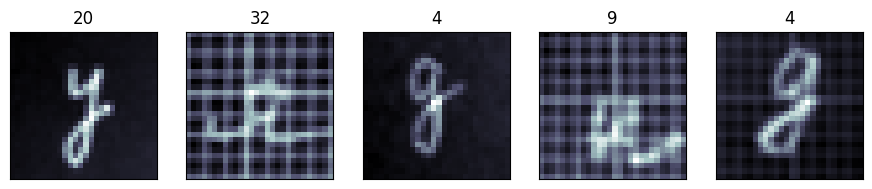

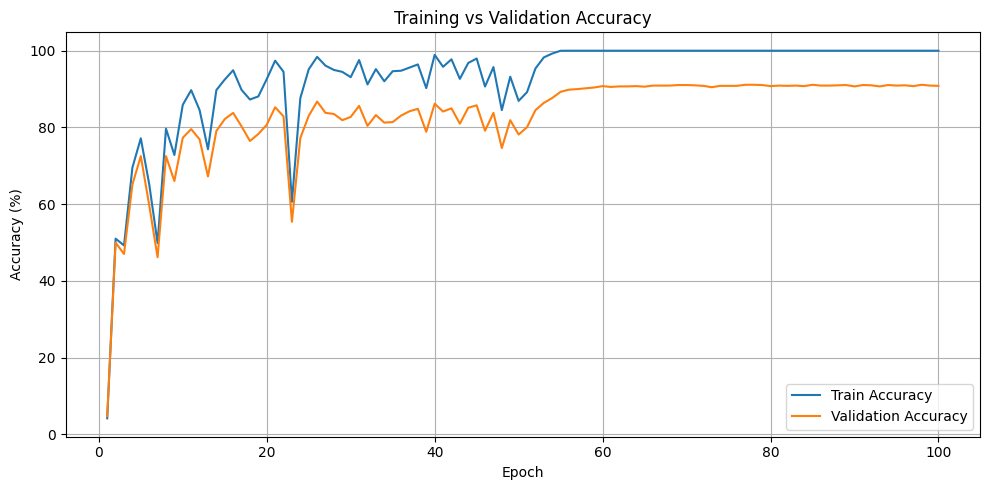

In [7]:
import numpy as np, pandas as pd, pylab as pl
import h5py, torch
from torch.utils.data import DataLoader as tdl, Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
import matplotlib.pyplot as plt

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Model 2
class TData(tds):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int32)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.y.shape[0]

# Display sample images from a data loader
def display_examples(data_loader, img_size):
    for images, labels in data_loader:
        print('Image dimensions:', images.shape)
        print('Label dimensions:', labels.shape)
        n = np.random.randint(1, 50)
        fig = pl.figure(figsize=(11, 4))
        for i in range(n, n + 5):
            ax = fig.add_subplot(1, 5, i - n + 1,
                                 xticks=[], yticks=[],
                                 title=labels[i].item())
            ax.imshow(images[i].reshape(img_size, img_size), cmap=pl.cm.bone)
        break

# Accuracy calculation
def model_acc(model, data_loader):
    correct_preds, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(dev)
        targets = targets.to(dev)
        logits, probs = model(features)
        _, pred_labels = torch.max(probs, 1)
        num_examples += targets.size(0)
        correct_preds += (pred_labels == targets).sum()
    return correct_preds.float() / num_examples * 100

# Dataset and DataLoader for Model 2
fpath = './dataset/'
img_size = 28
batch_size2 = 256

f_trainval = h5py.File(fpath + 'LetterColorImages_123.h5', 'r')
x_tv = 1 - np.array(f_trainval['images'], dtype='float32') / 255
x_tv = timage.resize(x_tv, [img_size, img_size])
x_tv = (np.dot(x_tv.numpy(), [.299, .587, .114])).reshape(-1, 1, img_size, img_size)
y_tv = np.array(f_trainval['labels'], dtype='int32') - 1

N = len(y_tv); n = int(.1 * N)
shuffle_ids = np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x_tv, y_tv = x_tv[shuffle_ids], y_tv[shuffle_ids]
x_valid, x_train = x_tv[n:2*n], x_tv[2*n:]
y_valid, y_train = y_tv[n:2*n], y_tv[2*n:]

train2 = TData(x_train, y_train)
valid2 = TData(x_valid, y_valid)
train_loader2 = tdl(dataset=train2, shuffle=True, batch_size=batch_size2)
valid_loader2 = tdl(dataset=valid2, shuffle=True, batch_size=batch_size2)

f_test = h5py.File(fpath + 'LetterColorImages.h5', 'r')
x_test = 1 - np.array(f_test['images'], dtype='float32') / 255
x_test = timage.resize(x_test, [img_size, img_size])
x_test = (np.dot(x_test.numpy(), [.299, .587, .114])).reshape(-1, 1, img_size, img_size)
y_test = np.array(f_test['labels'], dtype='int32') - 1

test2 = TData(x_test, y_test)
test_loader2 = tdl(dataset=test2, shuffle=False, batch_size=batch_size2)

display_examples(valid_loader2, img_size)

# ResNet model definition
def conv3x3(in_planes, out_planes, stride=1):
    return tnn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(tnn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = tnn.BatchNorm2d(planes)
        self.relu = tnn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = tnn.BatchNorm2d(planes)
        self.downsample = downsample
    def forward(self, x):
        residual = x
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.downsample is not None:
            residual = self.downsample(x)
        y += residual
        return self.relu(y)

class ResNet(tnn.Module):
    def __init__(self, block, layers, num_classes, grayscale=True):
        super(ResNet, self).__init__()
        self.inplanes = 64
        in_dim = 1 if grayscale else 3
        self.conv1 = tnn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = tnn.BatchNorm2d(64)
        self.relu = tnn.ReLU(inplace=True)
        self.maxpool = tnn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = tnn.AvgPool2d(7, stride=1)
        self.fc = tnn.Linear(512 * block.expansion, num_classes)
        self._init_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = tnn.Sequential(
                tnn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                tnn.BatchNorm2d(planes * block.expansion)
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        layers.extend(block(self.inplanes, planes) for _ in range(1, blocks))
        return tnn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, tnn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n) ** .5)
            elif isinstance(m, tnn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probs = tnnf.softmax(logits, dim=1)
        return logits, probs

def ResNN(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, grayscale=True)

# Training logic for Model 2
@register_line_magic
def train_run(epochs):
    epochs = int(epochs)
    train_acc_list, valid_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        for batch_ids, (features, targets) in enumerate(train_loader2):        
            features, targets = features.to(dev), targets.to(dev)
            logits, probs = model(features)
            cost = tnn.functional.cross_entropy(logits, targets.long())
            optimizer2.zero_grad()
            cost.backward()
            optimizer2.step()

            if not batch_ids % 50:
                print(f'Epoch: {epoch+1:03d}/{epochs:03d} | Batch {batch_ids:03d}/{len(train2)//batch_size2:03d} | Cost: {cost:.4f}')
        
        model.eval()
        with torch.no_grad():
            train_acc = model_acc(model, train_loader2)
            valid_acc = model_acc(model, valid_loader2)
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())
            print(f'Epoch: {epoch+1:03d}/{epochs:03d} train acc: {train_acc:.2f}% valid acc: {valid_acc:.2f}%')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, epochs+1), valid_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

@register_line_magic
def print_acc(n):
    print('Train accuracy: %.4f%%' % model_acc(model, train_loader2))
    print('Valid accuracy: %.4f%%' % model_acc(model, valid_loader2))
    print('Test accuracy: %.4f%%' % model_acc(model, test_loader2))

# Initialize Model 2
torch.manual_seed(12)
num_classes = 33
learning_rate = .001
model = ResNN(num_classes)
model.to(dev)
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

# To run training and check accuracy:
%train_run 100


In [8]:
%print_acc 2

Train accuracy: 100.0000%
Valid accuracy: 90.8386%
Test accuracy: 93.8182%
